# SLACS constraints
This notebook performs the hierarchical inference on the mass profiles and stellar anisotropy of the massive elliptical galaxies of the SLACS sample.

We are using SDSS spectra for the velocity dispersion measurements and VIMOS IFU observations to derive anisotropy constraints (in combination with imaging modeling of the mass distribution)

The inference is based on the lens models by Shajib, Treu, Birrer (2020).
The velocity dispersion meausrements are from SDSS (with re-calibration by Adam Bolton) and VIMOS IFU data (presented by Czoske et al. 2008).

This notebook is meant to demonstrate the constraining power of the SLACS sample on the mass profiles.

Author: Simon Birrer

last edits: 28.6.2020

In [1]:
# some standard python imports #
import copy
import numpy as np
import corner
import emcee
import pickle
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from os.path import dirname, abspath
%matplotlib inline

# we give it a random seed to produce the identical plots
np.random.seed(seed=10)

from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

# import the hierArc, lenstronomy and astropy classes
from hierarc.Sampling.mcmc_sampling import MCMCSampler
from astropy.cosmology import FlatLambdaCDM
from hierarc.Diagnostics.goodness_of_fit import GoodnessOfFit
from lenstronomy.Plots import plot_util

path2Analysis = dirname(abspath(os.getcwd()))

path2slacs = 'SLACS_sample'
path2kappa = os.path.join(path2Analysis, path2slacs, 'kappaSLACS')
file_name_slacs = os.path.join(path2Analysis, path2slacs, 'slacs_all_params.csv')

In [2]:
# we chose an anisotropy model parameterization. 
# Available are 'OM' (Osipkov&Merritt) and 'GOM' (generalized OM) based on Agnello et al. 2014
anisotropy_model = 'OM' # 'OM', 'GOM' 

# we describe the population distribution of the anisotropy parameters with a GAUSSIAN. 
# Available are 'GAUSSIAN' and 'NONE' (single valued distribution) 
anisotropy_distribution = 'GAUSSIAN'  # 'NONE' or 'GAUSSIAN'

# In this notebook, we assume a fixed cosmology to perform the inference. 
# This assumption is lifted when performing the joint constraints with the TDCOSMO sample.
H0 = 73
omega_m = 0.30
cosmo_fixed = FlatLambdaCDM(H0=H0, Om0=omega_m)

blinded = False  # blinded plots in regard to lambda_int

ifu_lambda_separate = True  # boolean, if True, samples a separate lambda_mst parameter for the IFU data (assuming the callibration is not fully accurate)
lambda_slope = True  # allow for linear scaling of lambda_int with r_eff/theta_E

num_distribution_draws = 200  # numerical setting for how many samples to draw from the distribution quantities to compute the marginalized likelihood in the sampling

# this is for saving the chains under different names
if ifu_lambda_separate is True:
    model_prefix = 'ifu_separate'
else:
    model_prefix = 'ifu_joint'

run_chains = False  # boolean, if True, runs the chains, else uses the stored chains to do the plotting 
continue_from_backend = True  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch 

n_walkers = 100  # number of walkers in the EMCEE 
# these settings are for shorter example runs that might not be fully converged
n_run = 200  # number of iterations that are stored
n_burn = 100  # number of burn-in iterations not stored

# import the SLACS sample

# selected slit lenses
# all SLACS lenses with power-law slopes measured from the quality sample of Shajib et al. 2020 passing our selection criteria (see sample_selection notebook) (excluding the lenses with additonal IFU data)
sdss_names_quality = ['SDSSJ1402+6321', 'SDSSJ1630+4520', 'SDSSJ0330-0020', 'SDSSJ0029-0055', 
                      'SDSSJ0728+3835', 'SDSSJ1112+0826', 'SDSSJ1306+0600', 'SDSSJ1531-0105', 
                      'SDSSJ1621+3931']
# all SLACS lenses including those with population prior from Shajib et al. 2020 passing our selection criteria (see sample_selection notebook) (excluding the lenses with additonal IFU data)
sdss_names_all = ['SDSSJ1402+6321', 'SDSSJ1630+4520', 'SDSSJ0330-0020', 'SDSSJ0029-0055', 
                  'SDSSJ0728+3835', 'SDSSJ1112+0826', 'SDSSJ1306+0600', 'SDSSJ1531-0105', 
                  'SDSSJ1621+3931', 'SDSSJ1153+4612', 'SDSSJ0008-0004', 'SDSSJ0044+0113', 
                  'SDSSJ0959+4416', 'SDSSJ1016+3859', 'SDSSJ1020+1122', 'SDSSJ1134+6027', 
                  'SDSSJ1142+1001', 'SDSSJ1213+6708', 'SDSSJ1218+0830', 'SDSSJ1432+6317', 
                  'SDSSJ1644+2625', 'SDSSJ2347-0005', 'SDSSJ1023+4230', 'SDSSJ1403+0006']


# selected IFU lenses within the criteria
ifu_names_quality = ['SDSSJ1627-0053', 'SDSSJ2303+1422', 'SDSSJ1250+0523', 'SDSSJ1204+0358', 'SDSSJ0037-0942']
# all including population prior
ifu_names_all = ['SDSSJ1627-0053', 'SDSSJ2303+1422', 'SDSSJ1250+0523', 'SDSSJ1204+0358', 'SDSSJ0037-0942', 'SDSSJ0912+0029', 'SDSSJ2321-0939', 'SDSSJ0216-0813', 'SDSSJ1451-0239']

# here we joint the sample with and without IFU data
sdss_names_all += ifu_names_all
sdss_names_quality += ifu_names_quality


# the kinematic predictions and scaling with anisotropy parameters are pre-processed (see pre-processing notebook)
# and we import the pickle files containing all the relevant information for the likelihood to be evaluated with hierARc

if anisotropy_model == 'OM':
    ifu_sample_file_name = 'slacs_ifu_om_processed.pkl'
    sdss_sample_file_name = 'slacs_slit_om_processed.pkl'
elif anisotropy_model == 'GOM':
    ifu_sample_file_name = 'slacs_ifu_gom_processed.pkl'
    sdss_sample_file_name = 'slacs_ifu_gom_processed.pkl'

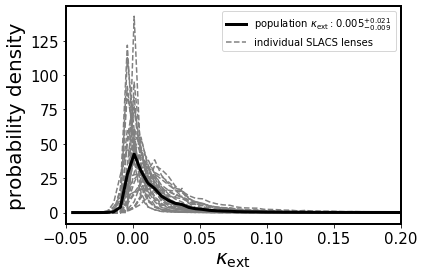

In [3]:
from hierarc.Util.distribution_util import PDFSampling

names_selected = sdss_names_all

percentiles = [16, 50, 84]
quantiles = [0.16, 0.5, 0.84]
title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
fmt = "{{0:{0}}}".format(".3f").format

# option with file ending
with_shear = False  # bool, if True, adds shear constraints in LOS estimate (only available for a subset of the sample)

kappa_choice_shear_ending = '_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_gamma_120_oneoverr_23.0_med_increments2_16_2_emptymsk_shearwithoutprior.cat'
kappa_choice_no_shear_ending = '_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat'

#'kappahist_SDSSJ2300+0022_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_oneoverr_23.0_med_increments2_emptymsk'
#'kappahist_SDSSJ2300+0022_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_23.0_med_increments2_emptymsk.cat'

if with_shear is True:
    kappa_choice_ending = kappa_choice_shear_ending
else:
    kappa_choice_ending = kappa_choice_no_shear_ending
    
    
kappa_bins = np.linspace(-0.05, 0.2, 50)


# loop through selected lenses

kappa_pdf_tot = np.zeros(len(kappa_bins)-1)
num_lenses = 0

for name in names_selected:
    filepath = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_ending)
 
    try:
        output = np.loadtxt(filepath, delimiter=' ', skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True) #, bins=kappa_bins
        kappa_pdf_tot += kappa_pdf
        plt.plot(kappa_bin_edges[1:], kappa_pdf, '--', color='gray')  # which do not include systematics and covariances 
        num_lenses += 1

    except:
        print('lens %s does not have a file %s' % (name, filepath))

kappa_pdf_tot /= num_lenses
kappa_bin_edges_tot = kappa_bin_edges

pdf_tot = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf_tot/num_lenses)
kappa_samples_tot = pdf_tot.draw(n=100000)
pcs = np.percentile(kappa_samples_tot, q=percentiles)
txt = r'$\kappa_{\rm ext}: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
plt.plot(kappa_bin_edges[1:], kappa_pdf_tot, '-k', linewidth=3, label='population ' + txt)        
        
plt.plot(-1, -1,  '--', color='gray', label=r'individual SLACS lenses')
plt.xlim([-0.05, 0.2])
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.legend()
plt.show()


def read_kappa_pdf(name, kappa_bins):
    filepath = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_ending)
    try:
        output = np.loadtxt(filepath, delimiter=' ', skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True)
        return kappa_pdf, kappa_bin_edges
    except:
        print('individual kappa_distribution for %s not available, using the population distribution instead.' %name)
        return kappa_pdf_tot, kappa_bin_edges_tot
    
def properties(name, file_name):
    with open(file_name, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if name == str(row['name']):
                theta_E = float(row['theta_E'])
                r_eff = float(row['r_eff'])
                return theta_E, r_eff


In [4]:


    
# here we read out the pickle files, remove unnecessary quantities and add relevant descriptions of the likelihood we are using in this notebook
kwargs_ifu_all_list = []
kwargs_ifu_quality_list = []

file = open(ifu_sample_file_name , 'rb')
posterior_ifu_list = pickle.load(file)
file.close()
for kwargs_posterior in posterior_ifu_list:
    name = kwargs_posterior['name']
    if name in sdss_names_all:
        kwargs_posterior_copy = copy.deepcopy(kwargs_posterior)
        if 'flag_ifu' in kwargs_posterior_copy:
            del kwargs_posterior_copy['flag_ifu']
        if 'flag_imaging' in kwargs_posterior_copy:  
            del kwargs_posterior_copy['flag_imaging']
        kwargs_posterior_copy['num_distribution_draws'] = num_distribution_draws
        kappa_pdf, kappa_bin_edges = read_kappa_pdf(name, kappa_bins)
        kwargs_posterior_copy['kappa_pdf'] = kappa_pdf
        kwargs_posterior_copy['kappa_bin_edges'] = kappa_bin_edges
        kwargs_posterior_copy['mst_ifu'] = ifu_lambda_separate
        theta_E, r_eff = properties(name, file_name_slacs)
        kwargs_posterior_copy['lambda_scaling_property'] = r_eff/theta_E - 1

        if name in ifu_names_quality:
            kwargs_ifu_quality_list.append(kwargs_posterior_copy)
        if name in ifu_names_all:
            kwargs_ifu_all_list.append(kwargs_posterior_copy)


kwargs_sdss_all_list = []
kwargs_sdss_quality_list = []

file = open(sdss_sample_file_name , 'rb')
posterior_sdss_list = pickle.load(file)
file.close()
for kwargs_posterior in posterior_sdss_list:
    name = kwargs_posterior['name']
    if name in sdss_names_all:
        kwargs_posterior_copy = copy.deepcopy(kwargs_posterior)
        if 'flag_ifu' in kwargs_posterior_copy:
            del kwargs_posterior_copy['flag_ifu']
        if 'flag_imaging' in kwargs_posterior_copy:  
            del kwargs_posterior_copy['flag_imaging']
        kwargs_posterior_copy['num_distribution_draws'] = num_distribution_draws
        kappa_pdf, kappa_bin_edges = read_kappa_pdf(name, kappa_bins)
        kwargs_posterior_copy['kappa_pdf'] = kappa_pdf
        kwargs_posterior_copy['kappa_bin_edges'] = kappa_bin_edges
        theta_E, r_eff = properties(name, file_name_slacs)
        kwargs_posterior_copy['lambda_scaling_property'] = r_eff/theta_E - 1

        if name in sdss_names_quality:
            kwargs_sdss_quality_list.append(kwargs_posterior_copy)
        if name in sdss_names_all:
            kwargs_sdss_all_list.append(kwargs_posterior_copy)

In this cell we define the settings for the hierarchical analysis

In [5]:
cosmology = 'FLCDM'  # available models: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'
# this is not relevant for this notebook as we fix the cosmology

# here we define the min/max range of allowed parameters in the anisotropy distributio
# These values have to be within the pre-processing range. Otherwise the predictions are off.
beta_inf_min, beta_inf_max = 0, 1
a_ani_min, a_ani_max, a_an_mean = 0.1, 5, 1


kwargs_lower_cosmo = {'h0': 0, 'om': 0.05}
kwargs_lower_lens = {'lambda_mst': 0.5, 'lambda_mst_sigma': 0, 'kappa_ext': -0.1, 'kappa_ext_sigma': 0, 'lambda_ifu': 0.5, 'lambda_ifu_sigma': 0, 'alpha_lambda': -1}
kwargs_lower_kin = {'a_ani': a_ani_min, 'a_ani_sigma': 0, 'beta_inf': beta_inf_min, 'beta_inf_sigma': 0}

kwargs_upper_cosmo = {'h0': 150, 'om': 0.5}
kwargs_upper_lens = {'lambda_mst': 1.5, 'lambda_mst_sigma': .5, 'kappa_ext': 0.2, 'kappa_ext_sigma': 0.2, 'lambda_ifu': 1.5, 'lambda_ifu_sigma': 0.5, 'alpha_lambda': 1}
kwargs_upper_kin = {'a_ani': a_ani_max, 'a_ani_sigma': 1. ,'beta_inf': beta_inf_max, 'beta_inf_sigma': 1}

# these values are held fixed throughout the entire sampling (optinal to add here)
kwargs_fixed_cosmo = {'h0': 70, 'om': 0.3}
kwargs_fixed_lens = {'kappa_ext_sigma': 0}

# for the 'GOM' model if you fix beta_inf =1 you should arrive to the same constraints as the 'OM' model
kwargs_fixed_kin = {}

# here we set the starting condition for the MCMC sampling
kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {'lambda_mst': 1., 'lambda_mst_sigma': .05, 'kappa_ext': 0, 'kappa_ext_sigma': 0.05, 'lambda_ifu': 1, 'lambda_ifu_sigma': 0.05, 'alpha_lambda': 0},
                     'kwargs_kin': {'a_ani': 1, 'a_ani_sigma': 0.1, 'beta_inf': 0.8, 'beta_inf_sigma': 0.1}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.1},
                     'kwargs_lens': {'lambda_mst': .1, 'lambda_mst_sigma': .05, 'kappa_ext': 0.01, 'kappa_ext_sigma': 0.05, 'lambda_ifu': 0.1, 'lambda_ifu_sigma': 0.05, 'alpha_lambda': 0.1},
                     'kwargs_kin': {'a_ani': 0.3, 'a_ani_sigma': 0.1, 'beta_inf': 0.5, 'beta_inf_sigma': 0.1}}




# we can define a custom prior for certain parameters (or combination thereof)
class CustomPrior(object):
    def __init__(self):
        pass
        
    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin)
    
    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin):
        # we do not impose a 1/a_ani prior when presenting the results on the SLACS lenses to better gage where the relevant information comes from

        logL = 0
        #a_ani = kwargs_kin.get('a_ani', 1)
        #logL += np.log(1/a_ani)
        return logL

# here we define the sampling settings
kwargs_sampler = {'lambda_mst_sampling': True,  # we allow a global internal MST to be sampled
                 'lambda_mst_distribution': 'GAUSSIAN',  # the distribution in the internal MST is assuemd Gaussian
                 'anisotropy_sampling': True,  # we sample the anisotropy parameters of our chosen model
                 'kappa_ext_sampling': False,  # we do not sample an external convergence distribution in this notebook. The parameter is degenerate with lambda_mst. We do however sample the external convergence distribution in the joint inference.
                 'kappa_ext_distribution': 'GAUSSIAN',
                 'sigma_v_systematics': False,  # we do not sample a systematic additional error term in the kinematics measurement. This parameter is degenerate with the infered spread in lambda_mst.
                 'anisotropy_model': anisotropy_model,  # our choice of anisotropy model
                 'anisotropy_distribution': anisotropy_distribution,
                 'alpha_lambda_sampling': lambda_slope,
                 'interpolate_cosmo': True, 'num_redshift_interp': 100,  # not relevant as we fix the cosmology
                 'custom_prior': CustomPrior(),  # custom prior
                 'cosmo_fixed': cosmo_fixed,  # we directly import the specific astropy.cosmology class to be held fixed throughout the sampling to avoid re-computing identical cosmologies in the sampling.
                 }

kwargs_sampler_combined = copy.deepcopy(kwargs_sampler)
kwargs_sampler_combined['lambda_ifu_sampling'] = ifu_lambda_separate
kwargs_sampler_combined['lambda_ifu_distribution'] = 'GAUSSIAN'

kwargs_sampler_ifu = copy.deepcopy(kwargs_sampler)
if ifu_lambda_separate is True:
    kwargs_sampler_ifu['lambda_ifu_sampling'] = ifu_lambda_separate
    kwargs_sampler_ifu['lambda_mst_sampling'] = False
    kwargs_sampler_ifu['alpha_lambda_sampling'] = False

kwargs_sampler_ifu['lambda_ifu_distribution'] = 'GAUSSIAN'


kwargs_bounds = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                'kwargs_lower_lens': kwargs_lower_lens,
                'kwargs_lower_kin': kwargs_lower_kin,
                'kwargs_upper_cosmo': kwargs_upper_cosmo,
                'kwargs_upper_lens': kwargs_upper_lens,
                'kwargs_upper_kin': kwargs_upper_kin,
                'kwargs_fixed_cosmo': kwargs_fixed_cosmo,
                'kwargs_fixed_lens': kwargs_fixed_lens,
                'kwargs_fixed_kin': kwargs_fixed_kin}

## IFU spectroscopic data set
Here we perform the hierarchical analysis on the IFU data only. We perform two runs, one with the quality sample only and one with all lenses passing the selection cut and imposing the population prior in $\gamma_{\rm pl}$.

In [7]:
# here we sample the IFU data jointly for the quality lenses

mcmc_sampler_ifu_quality = MCMCSampler(kwargs_ifu_quality_list, cosmology, kwargs_bounds, **kwargs_sampler_ifu)
ndim = mcmc_sampler_ifu_quality.param.num_param

filename = "ifu_quality_chain.h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_ifu_quality, log_prob_ifu_quality = mcmc_sampler_ifu_quality.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                         kwargs_mean_start, kwargs_sigma_start,
                                                                                         continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_ifu_quality = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_ifu_quality = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

if blinded is True:
    lambda_shift = 1 - np.mean(mcmc_samples_ifu_quality[:, 0])
else:
    lambda_shift = 0

mcmc_samples_ifu_quality_plot = copy.deepcopy(mcmc_samples_ifu_quality)
mcmc_samples_ifu_quality_plot[:, 0] += lambda_shift


In [8]:
# here we sample the IFU data jointly for all lenses (quality and sample prior)

mcmc_sampler_ifu_all = MCMCSampler(kwargs_ifu_all_list, cosmology, kwargs_bounds, **kwargs_sampler_ifu)

ndim = mcmc_sampler_ifu_all.param.num_param
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "ifu_all_chain.h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_ifu_all, log_prob_ifu_all = mcmc_sampler_ifu_all.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                             kwargs_mean_start, kwargs_sigma_start, 
                                                                             continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_ifu_all = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_ifu_all = backend.get_log_prob(discard=n_burn, flat=True, thin=1)



mcmc_samples_ifu_all_plot = copy.deepcopy(mcmc_samples_ifu_all)
mcmc_samples_ifu_all_plot[:, 0] += lambda_shift


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


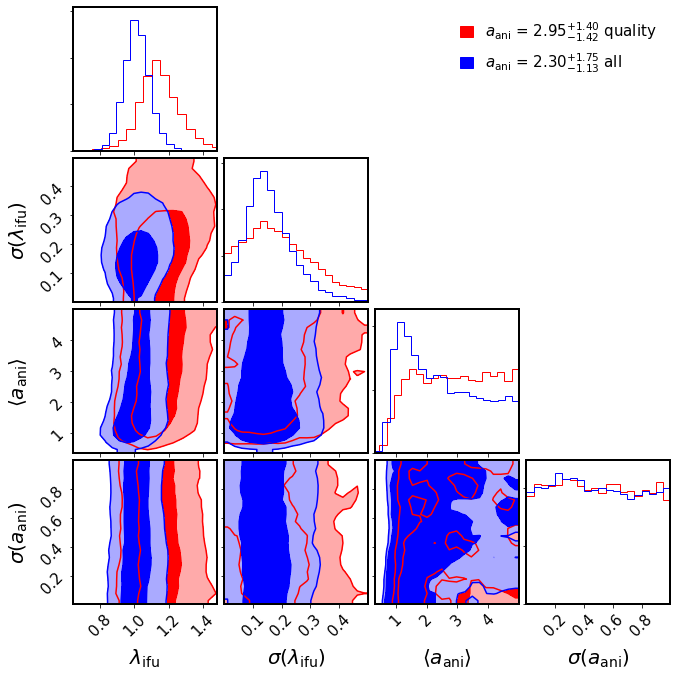

In [9]:
kwargs_corner = {'bins': 20, 'smooth': 0.7, 'smooth1d': None, 'plot_datapoints': False,
                 'label_kwargs': dict(fontsize=20), 'levels': [0.68,0.95],
                 'fill_contours': True, 'alpha': 0.2, 
                }

fig = corner.corner(mcmc_samples_ifu_quality_plot,
                    labels=mcmc_sampler_ifu_quality.param_names(latex_style=True),
                    color='r', hist_kwargs= {'density': True, 'color': 'r'}, **kwargs_corner)

fig = corner.corner(mcmc_samples_ifu_all_plot, color='b', fig=fig, hist_kwargs= {'density': True, 'color': 'b'}, **kwargs_corner)


ax = fig.axes[3]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
result_string_ifu_quality_ani = plot_util.result_string(mcmc_samples_ifu_quality_plot[:,2], weights=None, title_fmt=".2f", label=r'$a_{\rm ani}$')
result_string_ifu_all_ani = plot_util.result_string(mcmc_samples_ifu_all_plot[:,2], weights=None, title_fmt=".2f", label=r'$a_{\rm ani}$')

result_string_ifu_quality = plot_util.result_string(mcmc_samples_ifu_quality_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')
result_string_ifu_all = plot_util.result_string(mcmc_samples_ifu_all_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')


alpha= 1
patch_1 = mpatches.Patch(color='r', label=result_string_ifu_quality_ani+" quality", alpha=alpha)
patch_2 = mpatches.Patch(color='b', label=result_string_ifu_all_ani+" all", alpha=alpha)


ax.legend(handles=[patch_1, patch_2], fontsize=15, handlelength=0.9, loc=1, frameon=False)
fig.show()

#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/ifu_only_constraints.pdf')




Here we perform the inference on the anisotropy constraints for each IFU lens individually. In this case, we do not need sample distributions to be specified.

In [10]:
if False:  # this part is optinal to see the constraints from individual IFU lenses
    individual_samples_list = []
    for i, kwargs_ifu in enumerate(kwargs_ifu_quality_list):
        name = kwargs_ifu['name']
        print(name)
        mcmc_sampler = MCMCSampler([kwargs_ifu], cosmology, kwargs_bounds, ppn_sampling=False,
                     lambda_mst_sampling=True, lambda_mst_distribution='NONE', anisotropy_sampling=True,
                               kappa_ext_sampling=False, kappa_ext_distribution='NONE',
                     anisotropy_model=anisotropy_model, anisotropy_distribution='NONE', custom_prior=CustomPrior(), interpolate_cosmo=True, num_redshift_interp=100,
                     cosmo_fixed=cosmo_fixed)


        mcmc_samples, log_prob_cosmo = mcmc_sampler.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

        corner.corner(mcmc_samples, show_titles=True, labels=mcmc_sampler.param_names(latex_style=True))
        plt.show()
        individual_samples_list.append(mcmc_samples)


## SDSS spectra data set
Here we perform the inference on the SDSS spectra only.

In [11]:
mcmc_sampler_sdss_quality = MCMCSampler(kwargs_sdss_quality_list, cosmology, kwargs_bounds, **kwargs_sampler)

ndim = mcmc_sampler_sdss_quality.param.num_param
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "sdss_quality_chain.h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_sdss_quality, log_prob_sdss_quality = mcmc_sampler_sdss_quality.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                            kwargs_mean_start, kwargs_sigma_start, 
                                                                                            continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_sdss_quality = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_sdss_quality = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

if blinded is True:
    lambda_shift = 1 - np.mean(mcmc_samples_sdss_quality[:, 0])
else:
    lambda_shift = 0

mcmc_samples_sdss_quality_plot = copy.deepcopy(mcmc_samples_sdss_quality)
mcmc_samples_sdss_quality_plot[:, 0] += lambda_shift
    

In [12]:
mcmc_sampler_sdss_all = MCMCSampler(kwargs_sdss_all_list, cosmology, kwargs_bounds, **kwargs_sampler)

ndim = mcmc_sampler_sdss_all.param.num_param
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "sdss_all_chain.h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_sdss_all, log_prob_sdss_all = mcmc_sampler_sdss_all.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                kwargs_mean_start, kwargs_sigma_start, 
                                                                                continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_sdss_all = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_sdss_all = backend.get_log_prob(discard=n_burn, flat=True, thin=1)


mcmc_samples_sdss_all_plot = copy.deepcopy(mcmc_samples_sdss_all)
mcmc_samples_sdss_all_plot[:, 0] += lambda_shift

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


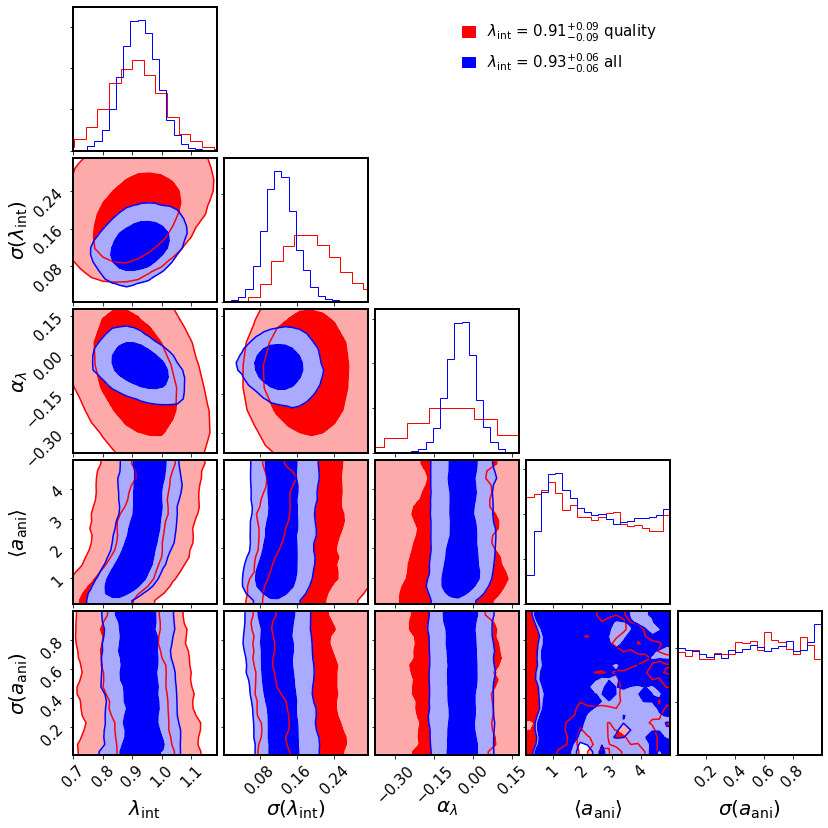

In [13]:
fig = corner.corner(mcmc_samples_sdss_quality_plot,
                    labels=mcmc_sampler_sdss_quality.param_names(latex_style=True),
                    color='r', hist_kwargs= {'density': True, 'color': 'r'}, **kwargs_corner)

fig = corner.corner(mcmc_samples_sdss_all_plot, color='b', hist_kwargs= {'density': True, 'color': 'b'}, fig=fig, **kwargs_corner)


ax = fig.axes[3]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
result_string_sdss_quality = plot_util.result_string(mcmc_samples_sdss_quality_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')
result_string_sdss_all = plot_util.result_string(mcmc_samples_sdss_all_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')


alpha= 1
patch_1 = mpatches.Patch(color='r', label=result_string_sdss_quality+" quality", alpha=alpha)
patch_2 = mpatches.Patch(color='b', label=result_string_sdss_all+" all", alpha=alpha)


ax.legend(handles=[patch_1, patch_2], fontsize=15, handlelength=0.9, loc=1, frameon=False)
fig.show()

#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/ifu_only_constraints.pdf')





## combining SDSS and IFU data
Here we combine the IFU and SDSS data set. Combining means that the lenses with IFU data appear twice in the likelihood, once with the SDSS velocity dispersion and once with the IFU radial dispersion measurements. The absolute normalization on the IFU kinematics is absorbed in lambda_ifu separate to the internal MST parameter on the SDSS measurements. In this form, only the anisotropy constraining power of the IFU data set is shared witht he SDSS measurements.

In [16]:
mcmc_sampler_combined_quality = MCMCSampler(kwargs_sdss_quality_list + kwargs_ifu_quality_list, cosmology, kwargs_bounds, **kwargs_sampler_combined)

filename = "combined_quality_chain"+model_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)

if run_chains is True:
    mcmc_samples_combined_quality, log_prob_combined_quality = mcmc_sampler_combined_quality.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                                        kwargs_mean_start, kwargs_sigma_start, 
                                                                                                        continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_combined_quality = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_combined_quality = backend.get_log_prob(discard=n_burn, flat=True, thin=1)
    
if blinded is True:
    lambda_shift = 1 - np.mean(mcmc_samples_combined_quality[:, 0])
else:
    lambda_shift = 0

mcmc_samples_combined_quality_plot = copy.deepcopy(mcmc_samples_combined_quality)
mcmc_samples_combined_quality_plot[:, 0] += lambda_shift

combined_quality_chainifu_separate.h5


In [17]:

mcmc_sampler_combined_all = MCMCSampler(kwargs_sdss_all_list + kwargs_ifu_all_list, cosmology, kwargs_bounds, **kwargs_sampler_combined)

filename = "combined_all_chain"+model_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_combined_all, log_prob_combined_all = mcmc_sampler_combined_all.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                            kwargs_mean_start, kwargs_sigma_start, 
                                                                                            continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_combined_all = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_combined_all = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

mcmc_samples_combined_all_plot = copy.deepcopy(mcmc_samples_combined_all)
mcmc_samples_combined_all_plot[:, 0] += lambda_shift

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


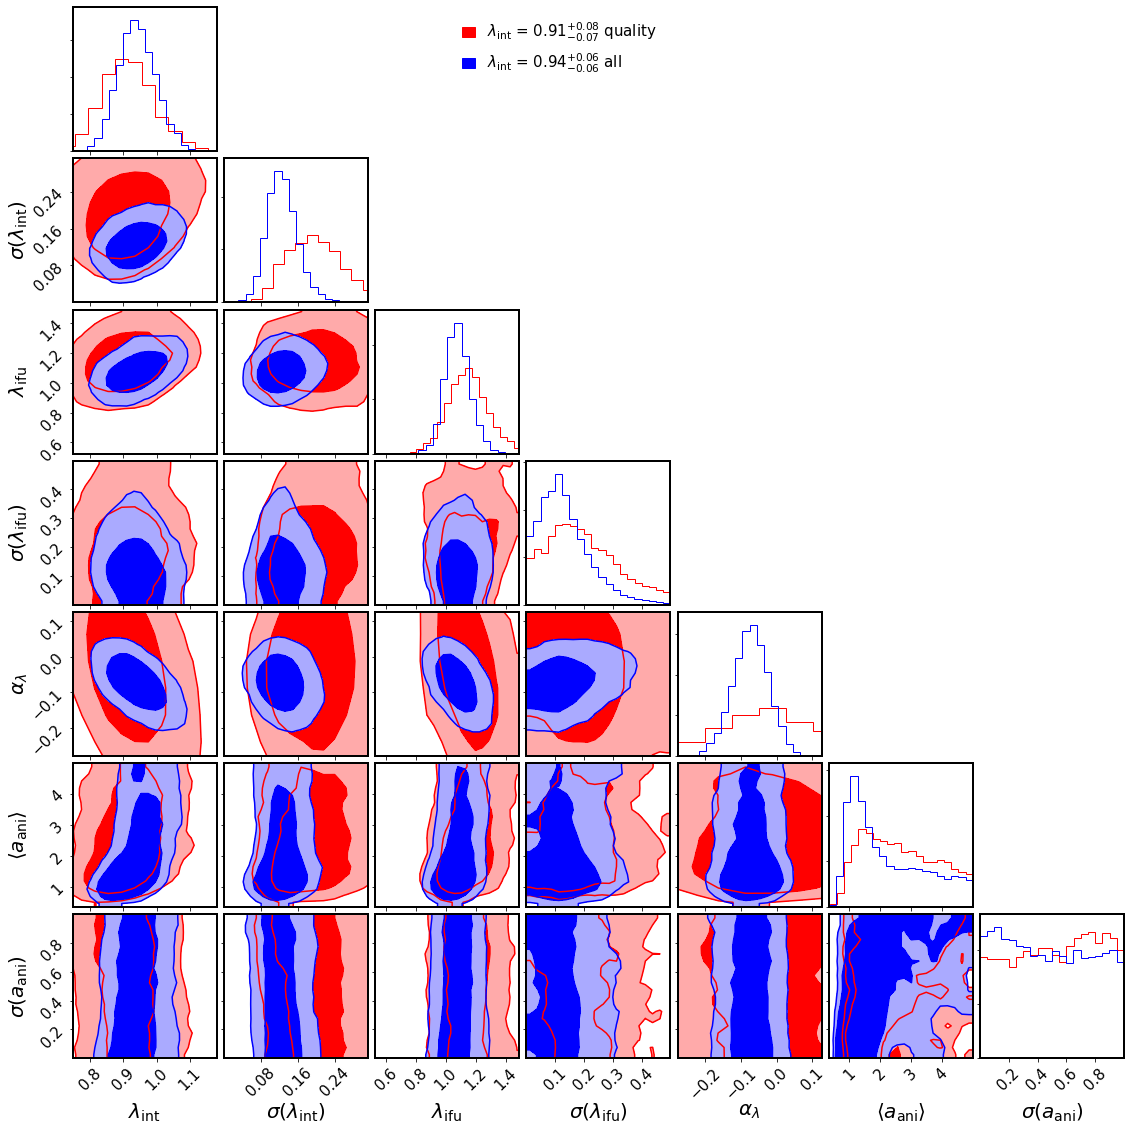

In [18]:

fig = corner.corner(mcmc_samples_combined_quality_plot,
                    labels=mcmc_sampler_combined_quality.param_names(latex_style=True),
                    color='r', hist_kwargs= {'density': True, 'color': 'r'}, **kwargs_corner)

fig = corner.corner(mcmc_samples_combined_all_plot, color='b', fig=fig, hist_kwargs= {'density': True, 'color': 'b'}, **kwargs_corner)

ax = fig.axes[3]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
result_string_combined_quality = plot_util.result_string(mcmc_samples_combined_quality_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')
result_string_combined_all = plot_util.result_string(mcmc_samples_combined_all_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')


alpha= 1
patch_1 = mpatches.Patch(color='r', label=result_string_combined_quality+" quality", alpha=alpha)
patch_2 = mpatches.Patch(color='b', label=result_string_combined_all+" all", alpha=alpha)

ax.legend(handles=[patch_1, patch_2], fontsize=15, handlelength=0.9, loc=1, frameon=False)
fig.show()

#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/ifu_only_constraints.pdf')






['lambda_mst', 'lambda_mst_sigma', 'lambda_ifu', 'lambda_ifu_sigma', 'alpha_lambda', 'a_ani', 'a_ani_sigma']
(50000, 5)


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


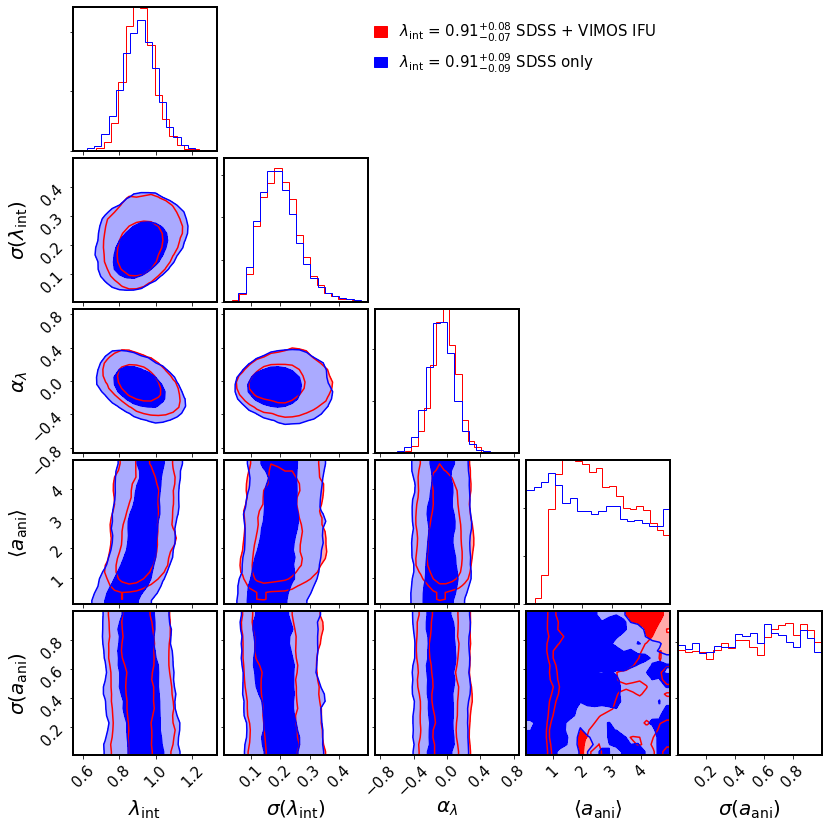

In [19]:
# comparison plot for quality lenses in the sample
print(mcmc_sampler_combined_quality.param_names())

def select_params(mcmc_samples, param_names, param_names_select):
    """
    selects a subset of the parameters to be plotted
    """
    
    keep_list = []
    for i, param_name in enumerate(param_names):
        if param_name in param_names_select:
            keep_list.append(i)
    mcmc_samples_select = copy.deepcopy(mcmc_samples.T[keep_list].T)
    return mcmc_samples_select

param_names_select = ['lambda_mst', 'lambda_mst_sigma', 'a_ani', 'a_ani_sigma', 'alpha_lambda']

mcmc_samples_combined_quality_select = select_params(mcmc_samples_combined_quality_plot, 
                                                     mcmc_sampler_combined_quality.param_names(), 
                                                     param_names_select)

mcmc_samples_sdss_quality_select = select_params(mcmc_samples_sdss_quality_plot, 
                                                     mcmc_sampler_sdss_quality.param_names(), 
                                                     param_names_select)


fig = corner.corner(mcmc_samples_combined_quality_select,
                    labels=mcmc_sampler_sdss_quality.param_names(latex_style=True),
                    color='r', hist_kwargs= {'density': True, 'color': 'r'}, **kwargs_corner)

print(np.shape(mcmc_samples_sdss_quality_select))
fig = corner.corner(mcmc_samples_sdss_quality_select, color='b', hist_kwargs= {'density': True, 'color': 'b'}, fig=fig, **kwargs_corner)

ax = fig.axes[3]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



alpha= 1
patch_1 = mpatches.Patch(color='r', label=result_string_combined_quality+" SDSS + VIMOS IFU", alpha=alpha)
patch_2 = mpatches.Patch(color='b', label=result_string_sdss_quality+" SDSS only", alpha=alpha)

ax.legend(handles=[patch_1, patch_2], fontsize=15, handlelength=0.9, loc=1, frameon=False)
fig.show()

#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/ifu_only_constraints.pdf')




/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


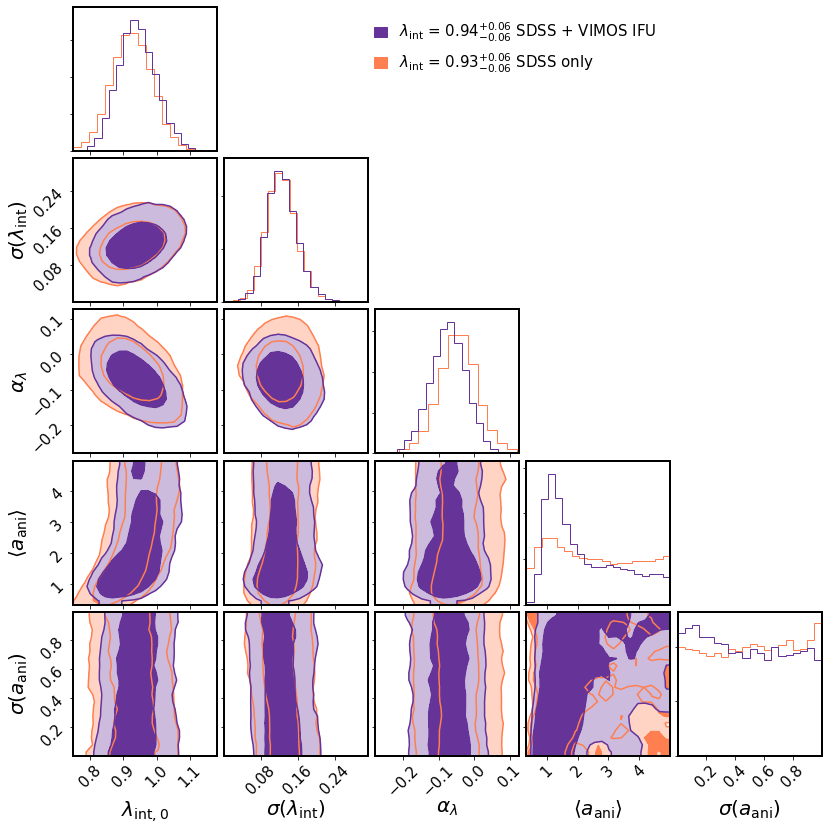

In [20]:
# comparison plot for all lenses in the sample

extents = None #[[0.8, 1.2], [0., 0.3], [0.1, 5], [0, 1]]

if lambda_slope is True:
    labels = [r'$\lambda_{\rm int,0}$', r'$\sigma(\lambda_{\rm int})$', r'$\alpha_{\lambda}$', r'$\langle a_{\rm ani}\rangle$', r'$\sigma(a_{\rm ani})$']
else:
    labels = [r'$\lambda_{\rm int,0}$', r'$\sigma(\lambda_{\rm int})$', r'$a_{\rm ani}$', r'$\sigma(a_{\rm ani})$']


mcmc_samples_sdss_all_select = select_params(mcmc_samples_sdss_all, 
                                                     mcmc_sampler_sdss_all.param_names(), 
                                                     param_names_select)


mcmc_samples_combined_all_select = select_params(mcmc_samples_combined_all, 
                                                     mcmc_sampler_combined_all.param_names(), 
                                                     param_names_select)


if blinded is True:
    lambda_shift = 1 - np.mean(mcmc_samples_combined_all_select[:, 0])
else:
    lambda_shift = 0

mcmc_sdss_plot = copy.deepcopy(mcmc_samples_sdss_all_select)
mcmc_sdss_plot[:, 0] += lambda_shift

mcmc_combined_plot = copy.deepcopy(mcmc_samples_combined_all_select)
mcmc_combined_plot[:, 0] += lambda_shift
    
#fig = corner.corner(mcmc_ifu_plot, color='g', 
#                    hist_kwargs= {'density': True, 'color': 'g'}, 
#                    range=extents, **kwargs_corner)

fig = corner.corner(mcmc_sdss_plot, color='coral', 
                    hist_kwargs= {'density': True, 'color': 'coral'}, 
                    range=extents, **kwargs_corner)

fig = corner.corner(mcmc_combined_plot, fig=fig,
                    labels=labels,
                    color='rebeccapurple', hist_kwargs= {'density': True, 'color': 'rebeccapurple'}, range=extents, **kwargs_corner)


ax = fig.axes[3]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

result_string_combined_all = plot_util.result_string(mcmc_combined_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')
result_string_sdss_all = plot_util.result_string(mcmc_sdss_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm int}$')
#result_string_ifu_all = plot_util.result_string(mcmc_ifu_plot[:,0], weights=None, title_fmt=".2f", label=r'$\lambda_{\rm mst}$')



alpha= 1
patch_1 = mpatches.Patch(color='rebeccapurple', label=result_string_combined_all+" SDSS + VIMOS IFU", alpha=alpha)
patch_2 = mpatches.Patch(color='coral', label=result_string_sdss_all+" SDSS only", alpha=alpha)
#patch_3 = mpatches.Patch(color='g', label=result_string_ifu_all+" VIMOS IFU only", alpha=alpha)

ax.legend(handles=[patch_1, patch_2], fontsize=15, handlelength=0.9, loc=1, frameon=False)
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/slacs_constraints'+model_prefix+'.pdf')
fig.show()


5 quality IFU lenses


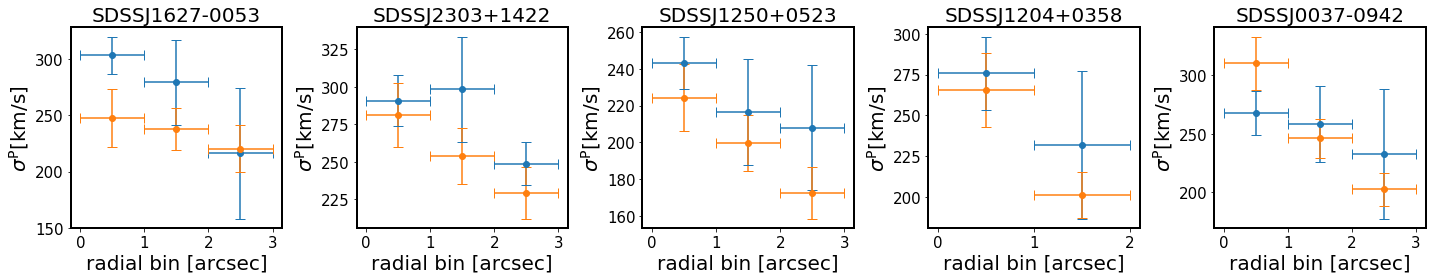

9 all IFU lenses


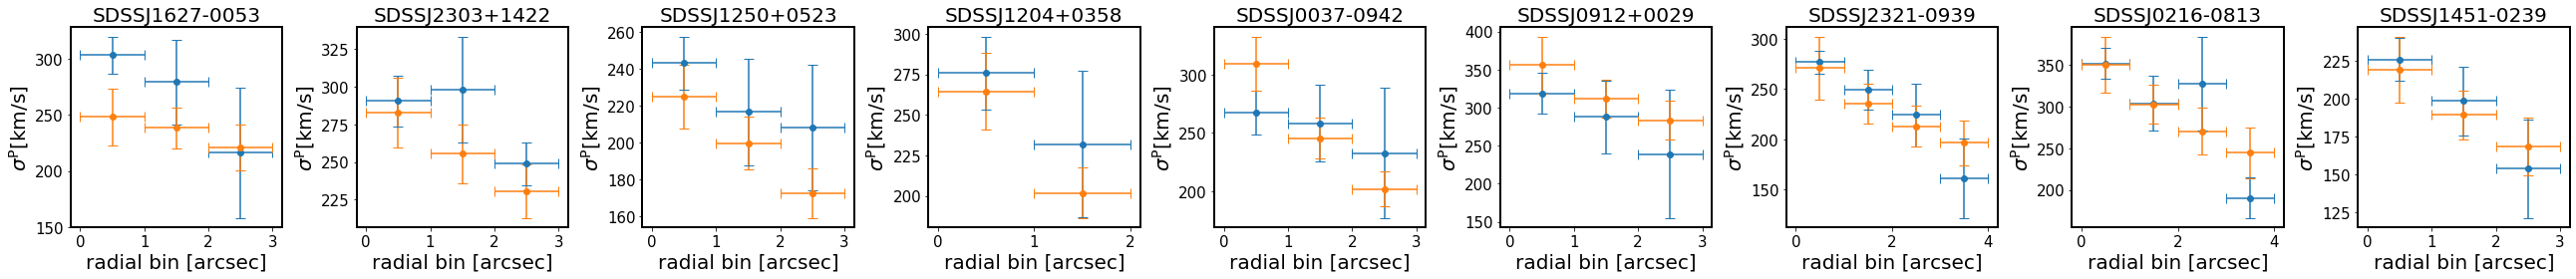

14 quality lenses
-68.16254524161432 log likelihood


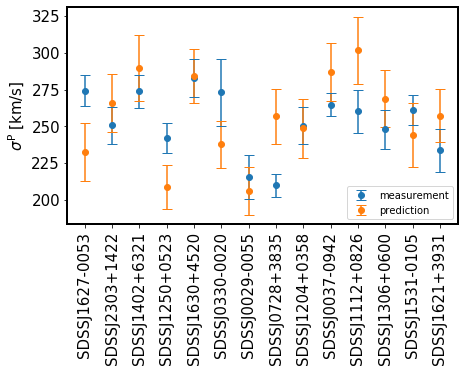

33 all lenses
-152.71341355496705 log likelihood


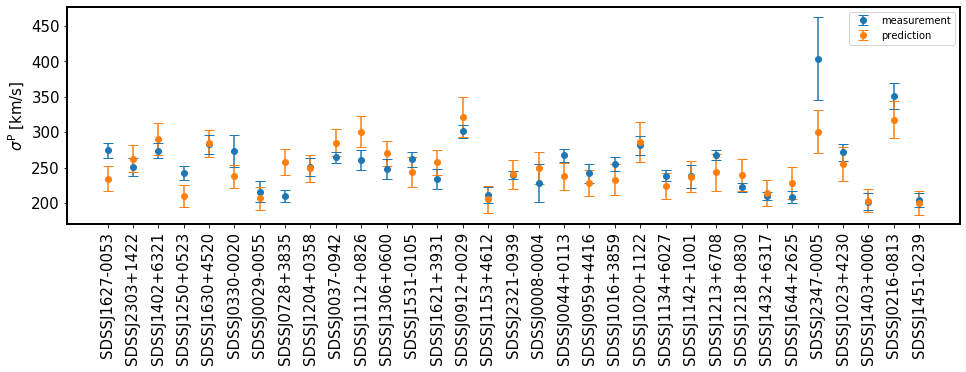

In [21]:
# goodness of fit diagnostics

# best fit model of all lenses + IFU data
mcmc_samples_combined_all

index_best_fit = np.where(log_prob_combined_all == np.max(log_prob_combined_all))

kwargs_cosmo_best_fit, kwargs_lens_best_fit, kwargs_kin_best_fit = mcmc_sampler_combined_all.param.args2kwargs(mcmc_samples_combined_all[index_best_fit[0][0]])
cosmo_best_fit = mcmc_sampler_combined_all.param.cosmo(kwargs_cosmo_best_fit)


fit = GoodnessOfFit(kwargs_ifu_quality_list)

num_lenses = len(kwargs_ifu_quality_list)
print(num_lenses, "quality IFU lenses")
f, axes = plt.subplots(1, num_lenses, figsize=(4*num_lenses, 4))

for lens_index, kwargs_ifu in enumerate(kwargs_ifu_quality_list):
    ax = fit.plot_ifu_fit(ax=axes[lens_index], cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit,
             kwargs_kin=kwargs_kin_best_fit, lens_index=lens_index, show_legend=False, radial_bin_size=1)
plt.tight_layout()
plt.show()


fit = GoodnessOfFit(kwargs_ifu_all_list)

num_lenses = len(kwargs_ifu_all_list)
print(num_lenses, "all IFU lenses")
f, axes = plt.subplots(1, num_lenses, figsize=(4*num_lenses, 4))

for lens_index, kwargs_ifu in enumerate(kwargs_ifu_all_list):
    ax = fit.plot_ifu_fit(ax=axes[lens_index], cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit,
             kwargs_kin=kwargs_kin_best_fit, lens_index=lens_index, show_legend=False, radial_bin_size=1)
plt.tight_layout()
plt.show()

print(len(kwargs_sdss_quality_list), 'quality lenses')
fit = GoodnessOfFit(kwargs_sdss_quality_list)
fig, axes = fit.plot_kin_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit,
             kwargs_kin=kwargs_kin_best_fit)
plt.show()

print(len(kwargs_sdss_all_list), 'all lenses')
fit = GoodnessOfFit(kwargs_sdss_all_list)
fig, axes = fit.plot_kin_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit,
             kwargs_kin=kwargs_kin_best_fit)
plt.show()